### Importe de librerias 


In [1]:
#Para poner la barra de progreso durante el entrenamiento 
!pip install tqdm
import sys
!"{sys.executable}" -m pip install tqdm 

In [2]:
import pennylane as qml
import numpy as np
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import pickle
from scipy.stats import truncnorm
import math

### Definición del dispositivo y número de qubits

Un dispositivo cuántico es un objeto que representa el backend donde se ejecuta el circuito cuántico.

qml.device carga un dispositivo cuántico particular.

'default.qubit':un simulador de estados puros.

'default.mixed':un simulador de estados mezclados.

In [3]:
#Definición del dispositivo cuántico
dev = qml.device("default.mixed", wires=4)

### Arquitectura del Circuito 


Un QNode es una función que contiene al circuito variacional y el dispositivo computacional en el que se ejecuta.

interface="autograd": le dice a PennyLane que los parámetros serán diferenciables con autograd (la librería automática de derivación).

qml.QubitDensityMatrix requiere el estado total del sistema completo.

Toma el estado base (qubits 0 y 1 en |00⟩⟨00|) y lo combina con el estado rho (en qubits 2 y 3) para formar el estado de los 4 qubits juntos.


In [4]:

@qml.qnode(dev) #Decorador para definir el circuito cuántico
def Circuit(params, rho):
    # Crear estado |00⟩⟨00| para qubits 0 y 1
    base = pnp.zeros((4,4), dtype=complex)
    base[0,0] = 1.0 # Para poner la primera entrada de la matriz en 1 y el resto en 0
    
    # Producto tensorial para obtener estado total de 4 qubits
    full_state = pnp.kron(base, rho)
    
    # Usar en el dispositivo de 4 qubits
    qml.QubitDensityMatrix(full_state, wires=[0, 1, 2, 3])
    
    qml.Rot(params[0], params[1], params[2], wires=0)
    qml.Rot(params[3], params[4], params[5], wires=1)
    qml.Rot(params[6], params[7], params[8], wires=2)
    qml.Rot(params[9], params[10], params[11], wires=3)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[3, 0])

    # La compuerta v1 opera si el qubit de control (0) está en |1⟩


    qml.PauliX(wires=0)

    qml.ctrl(qml.Rot(params[12], params[13], params[14], wires=1), control=0)
    qml.ctrl(qml.Rot(params[15], params[16], params[17], wires=2), control=0)
    qml.ctrl(qml.Rot(params[18], params[19], params[20], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)

    qml.PauliX(wires=0)

    # La compuerta v2 opera si el qubit de control (0) está en |0⟩


    qml.ctrl(qml.Rot(params[21], params[22], params[23], wires=1), control=0)
    qml.ctrl(qml.Rot(params[24], params[25], params[26], wires=2), control=0)
    qml.ctrl(qml.Rot(params[27], params[28], params[29], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)    
    
    return qml.probs(wires=[0, 1]) 



### Definición de las familias 

dtype= complex porque aunque las matrices se definan para parametros a y b reales, 
la evolución del sistema si puede introducir números complejos.

In [5]:
def ρ1(a):
    
    psi1 = pnp.array([np.sqrt(1 - a*a), 0.0, a, 0.0], dtype=complex)
    rho1 = pnp.outer(psi1, psi1.conj())
    return rho1, 1

def ρ2(b):

    psi2 = pnp.array([0.0, np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    psi3 = pnp.array([0.0, -np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    rho2 = 0.5 * np.outer(psi2, psi2.conj()) + 0.5 * np.outer(psi3, psi3.conj())

    return rho2, 2
    

### Conjunto de Datos de Prueba 

Para el caso de la distribución uniforme

In [6]:
np.random.seed(2)
n_test = 10000
data_test = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_test//3)

for a in a_values:
    rho, label = ρ1(a)
    data_test.append((rho, label))

b_test = np.random.uniform(0, 1, math.ceil(n_test*(2/3)))
for b in b_test:
    rho, label = ρ2(b)
    data_test.append((rho, label))

### Conjunto de Datos de Entrenamiento 


In [7]:
np.random.seed(90701)
n_samples = 600
data = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_samples//3)
for a in a_values:
    rho, label = ρ1(a)
    data.append((rho, label))  


b_values = np.random.uniform(0, 1, math.ceil(n_samples*(2/3)))
for b in b_values:
    rho, label = ρ2(b)
    data.append((rho, label))

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

### Función de Pérdida 


In [8]:
# Funciones de pérdida

# Clasificación mínimo error (Probabilidad de inconclusión casi nula)

alpha_err = 0  # penaliza los errores
alpha_inc = 2 # penaliza los resultados inconclusos


# Función de pérdida para una muestra según el label:
# label 1: familia 1 se espera que los outcomes 00 y 10 sean correctos.
# label 2: familia 2 se espera que el outcome 01 sea correcto.

def sample_loss(params, rho, label):
    
    probs = Circuit(params, rho)
    # |00> -> probs[0], |01> -> probs[1], |10> -> probs[2], |11> -> probs[3]
    if label == 1:
        # Familia 1 => éxito: (|00>, |10>), error: |01>, inconcluso: |11>
        p_suc = (probs[0] + probs[2])
        p_err = probs[1]
        p_inc = probs[3]
    else:
        # Familia 2 => éxito: |01>, error: (|00>, |10>), inconcluso: |11>
        p_suc = probs[1]
        p_err = probs[0] + probs[2]
        p_inc = probs[3]
        
    return (
    pnp.abs(p_suc - 1.0)
    + alpha_err * pnp.abs(p_err - 0.0)
    + alpha_inc * pnp.abs(p_inc - 0.0)
    )

# Función global de pérdida que promedia sobre el conjunto de muestras

def loss(params, samples):
    total = pnp.array(0.0, requires_grad=True) #iniciar el acumulador del costo total,
    #asegurar que ese acumulador soporta derivación automática, y permitir que luego PennyLane optimice los parámetros con gradientes.  

    for (rho, label) in samples:
        total = total + sample_loss(params, rho, label)

    avg = total / len(samples)           
    return avg  

In [9]:
def get_probabilities(params, rho, label):
    """Calcula las probabilidades de salida del circuito, dada la matriz de densidad."""
    
    return Circuit(params, rho)


### Evaluación del modelo

In [10]:
def evaluate_model(params, samples):
    """Evalúa tasas promedio de éxito, error e inconcluso en cada familia."""
    
    # Separar por familia
    S1 = [rho for (rho, label) in samples if label == 1]
    S2 = [rho for (rho, label) in samples if label == 2]

    total_suc_1, total_err_1, total_inc_1 = 0, 0, 0
    total_suc_2, total_err_2, total_inc_2 = 0, 0, 0

    for rho in S1:
        probs = get_probabilities(params, rho, 1)
        total_suc_1 += probs[0] + probs[2]  # éxito
        total_err_1 += probs[1]
        total_inc_1 += probs[3]

    for rho in S2:
        probs = get_probabilities(params, rho, 2)
        total_suc_2 += probs[1]             # éxito
        total_err_2 += probs[0] + probs[2]
        total_inc_2 += probs[3]

    # Promedios por familia
    n1, n2 = len(S1), len(S2)
    suc = (total_suc_1 + total_suc_2) / (n1 + n2)
    err = (total_err_1 + total_err_2) / (n1 + n2)
    inc = (total_inc_1 + total_inc_2) / (n1 + n2)

    return suc, err, inc


In [11]:
def get_batches(data, batch_size):
    # Asegurar que batch_size sea al menos 1
    batch_size = max(1, int(batch_size))
    
    # Mezclar los datos
    data_shuffled = random.sample(data, len(data))
    
    # Crear los lotes
    return [data_shuffled[i:i+batch_size] for i in range(0, len(data), batch_size)]


### Entrenamiento del modelo


params, curr_loss = opt.step_and_cost(lambda v: loss(v, data_train), params)

opt: Optimizador
.step_and_cost(...): Método que actualiza los parámetros y devuelve el valor de la función de costo


Calcula el valor de la función de la función de costo (loss(...)) para los parámetros actuales.
Calcula el gradiente de esa función de costo con respecto a los parámetros.
Actualiza los parámetros en la dirección que reduce la función de costo.

Devuelve:

params: los nuevos parámetros después de actualizar.

curr_loss: el valor actual de la función de costo.

La función lambda hace que el optimizador calcule la función de costo con los parámetros v usando el conjunto de datos data_train que ya está fijado.



In [12]:
opt = qml.AdamOptimizer(stepsize=0.01)
n_iter = 5000
batch_size = int(len(data_train) * 0.2)
val_batch_size = int(0.2 * batch_size)

initial_params = np.random.uniform(0, 2 * np.pi, 30)
params = pnp.array(initial_params, requires_grad=True)

# Early stopping
patience = 500
min_delta = 1e-4
best_val_loss = float('inf')
patience_counter = 0
best_params = params.copy()  # Guardar los mejores parámetros

# ReduceLROnPlateau
plateau_patience = 150
plateau_factor = 0.5
min_lr = 1e-5
plateau_counter = 0

# Historiales
loss_history = []
val_loss_history = []
train_suc_history = []
train_err_history = []
train_inc_history = []
val_suc_history = []
val_err_history = []
val_inc_history = []

for it in tqdm(range(n_iter), desc="Entrenando"):

    # Batch aleatorio
    batch = random.sample(data_train, batch_size)

    # Paso de entrenamiento
    params, train_loss = opt.step_and_cost(lambda v: loss(v, batch), params)

    # Evaluación en validación
    val_batches = get_batches(data_val, val_batch_size)
    val_loss = 0
    for vb in val_batches:
        val_loss += loss(params, vb) * len(vb)
    val_loss /= len(data_val)

    # EARLY STOPPING 
    if val_loss < best_val_loss - min_delta:  # Mejora significativa
        best_val_loss = val_loss
        best_params = params.copy()  # Guardar mejores parámetros
        patience_counter = 0
        plateau_counter = 0  # reinicia ambos contadores
    else:
        patience_counter += 1
        plateau_counter += 1

    # REDUCE LR ON PLATEAU 
    if plateau_counter >= plateau_patience:
        new_lr = max(opt.stepsize * plateau_factor, min_lr)
        if new_lr < opt.stepsize:
            print(f"Reducción de learning rate: {opt.stepsize:.5f} → {new_lr:.5f}")
            opt.stepsize = new_lr
            plateau_counter = 0  # Reiniciar después de reducir LR

    # STOPPING 
    if patience_counter >= patience:
        print(f"Early stopping en iteración {it+1}. Mejor pérdida de validación: {best_val_loss:.6f}")
        params = best_params  # Restaurar mejores parámetros
        break

    # Evaluación en train, test y validación
    suc_train, err_train, inc_train = evaluate_model(params, data_train)
    suc_val, err_val, inc_val = evaluate_model(params, data_val)


    # Guardar métricas
    loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_suc_history.append(suc_train)
    train_err_history.append(err_train)
    train_inc_history.append(inc_train)
    val_suc_history.append(suc_val)
    val_err_history.append(err_val)
    val_inc_history.append(inc_val)

    if (it + 1) % 50 == 0:
        print(f"Iter {it+1:3d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
              f"train_suc={suc_train:.3f}, train_err={err_train:.3f}, train_inc={inc_train:.3f} | "
              f"val_suc={suc_val:.3f}, val_err={err_val:.3f}, val_inc={inc_val:.3f}") 
    if (it + 1) % 100 == 0:
        print(f"Iter {it+1}: LR actual = {opt.stepsize:.6f}")

# Usar los mejores parámetros al final
params = best_params

# Final
print("\nParámetros entrenados:")
print(params)

print("\nResultados finales en el conjunto de prueba:")
test_suc, test_err, test_inc = evaluate_model(params, data_test)
print(f"  Éxito promedio     = {test_suc:.4f}")
print(f"  Error promedio     = {test_err:.4f}")
print(f"  Inconcluso promedio = {test_inc:.4f}")




Entrenando:   0%|          | 0/5000 [00:00<?, ?it/s]

Entrenando:   0%|          | 1/5000 [01:06<92:14:20, 66.43s/it]

Entrenando:   0%|          | 2/5000 [02:02<83:34:46, 60.20s/it]

Entrenando:   0%|          | 3/5000 [03:15<92:04:09, 66.33s/it]

Entrenando:   0%|          | 4/5000 [04:31<97:05:27, 69.96s/it]

Entrenando:   0%|          | 5/5000 [05:42<97:33:17, 70.31s/it]

Entrenando:   0%|          | 6/5000 [06:53<98:04:02, 70.69s/it]

Entrenando:   0%|          | 7/5000 [08:09<100:14:44, 72.28s/it]

Entrenando:   0%|          | 8/5000 [09:21<100:09:56, 72.23s/it]

Entrenando:   0%|          | 9/5000 [10:32<99:44:17, 71.94s/it] 

Entrenando:   0%|          | 10/5000 [11:51<102:37:17, 74.04s/it]

Entrenando:   0%|          | 11/5000 [13:31<113:34:21, 81.95s/it]

Entrenando:   0%|          | 12/5000 [15:16<123:30:58, 89.15s/it]

Entrenando:   0%|          | 13/5000 [17:07<132:36:02, 95.72s/it]

Entrenando:   0%|          | 14/5000 [18:53<136:38:35, 98.66s/it]

Entrenando:   0%|          | 15/5000 [20:36<138:36:58, 100.10s/it]

Entrenando:   0%|          | 16/5000 [22:29<143:54:56, 103.95s/it]

Entrenando:   0%|          | 17/5000 [24:15<144:48:56, 104.62s/it]

Entrenando:   0%|          | 18/5000 [25:58<144:02:41, 104.09s/it]

Entrenando:   0%|          | 19/5000 [27:49<146:59:22, 106.24s/it]

Entrenando:   0%|          | 20/5000 [29:40<148:34:11, 107.40s/it]

Entrenando:   0%|          | 21/5000 [31:34<151:40:53, 109.67s/it]

Entrenando:   0%|          | 22/5000 [33:19<149:20:53, 108.01s/it]

Entrenando:   0%|          | 23/5000 [35:42<163:52:04, 118.53s/it]

Entrenando:   0%|          | 24/5000 [38:10<176:18:23, 127.55s/it]

Entrenando:   0%|          | 25/5000 [40:28<180:18:58, 130.48s/it]

Entrenando:   1%|          | 26/5000 [42:44<182:54:34, 132.38s/it]

Entrenando:   1%|          | 27/5000 [45:01<184:36:47, 133.64s/it]

Entrenando:   1%|          | 28/5000 [47:17<185:44:09, 134.48s/it]

Entrenando:   1%|          | 29/5000 [49:33<186:11:53, 134.84s/it]

Entrenando:   1%|          | 30/5000 [51:50<186:58:55, 135.44s/it]

Entrenando:   1%|          | 31/5000 [54:06<187:23:56, 135.77s/it]

Entrenando:   1%|          | 32/5000 [56:22<187:18:41, 135.73s/it]

Entrenando:   1%|          | 33/5000 [58:39<187:56:19, 136.21s/it]

Entrenando:   1%|          | 34/5000 [1:00:55<187:41:39, 136.07s/it]

Entrenando:   1%|          | 35/5000 [1:03:11<187:30:45, 135.96s/it]

Entrenando:   1%|          | 36/5000 [1:05:30<188:54:20, 137.00s/it]

Entrenando:   1%|          | 37/5000 [1:07:59<193:33:46, 140.40s/it]

Entrenando:   1%|          | 38/5000 [1:10:22<194:53:17, 141.39s/it]

Entrenando:   1%|          | 39/5000 [1:12:50<197:21:57, 143.22s/it]

Entrenando:   1%|          | 40/5000 [1:15:16<198:29:19, 144.06s/it]

Entrenando:   1%|          | 41/5000 [1:17:43<199:34:05, 144.88s/it]

Entrenando:   1%|          | 42/5000 [1:20:07<199:09:33, 144.61s/it]

Entrenando:   1%|          | 43/5000 [1:22:31<198:57:44, 144.50s/it]

Entrenando:   1%|          | 44/5000 [1:24:46<195:05:08, 141.71s/it]

Entrenando:   1%|          | 45/5000 [1:26:51<188:09:02, 136.70s/it]

Entrenando:   1%|          | 46/5000 [1:28:57<183:41:59, 133.49s/it]

Entrenando:   1%|          | 47/5000 [1:30:54<176:40:07, 128.41s/it]

Entrenando:   1%|          | 48/5000 [1:32:44<169:18:36, 123.08s/it]

Entrenando:   1%|          | 49/5000 [1:34:32<162:58:50, 118.51s/it]

Entrenando:   1%|          | 50/5000 [1:36:25<160:27:38, 116.70s/it]

Iter  50: train_loss=1.1037, val_loss=1.0552, train_suc=0.413, train_err=0.325, train_inc=0.262 | val_suc=0.439, val_err=0.313, val_inc=0.247


Entrenando:   1%|          | 51/5000 [1:38:10<155:34:32, 113.17s/it]

Entrenando:   1%|          | 52/5000 [1:39:55<152:16:37, 110.79s/it]

Entrenando:   1%|          | 53/5000 [1:41:35<148:04:56, 107.76s/it]

Entrenando:   1%|          | 54/5000 [1:43:17<145:28:12, 105.88s/it]

Entrenando:   1%|          | 55/5000 [1:44:59<143:57:48, 104.81s/it]

Entrenando:   1%|          | 56/5000 [1:46:39<141:57:42, 103.37s/it]

Entrenando:   1%|          | 57/5000 [1:48:23<142:08:48, 103.53s/it]

Entrenando:   1%|          | 58/5000 [1:50:10<143:21:25, 104.43s/it]

Entrenando:   1%|          | 59/5000 [1:51:59<145:27:46, 105.98s/it]

Entrenando:   1%|          | 60/5000 [1:53:46<145:51:46, 106.30s/it]

Entrenando:   1%|          | 61/5000 [1:55:29<144:21:12, 105.22s/it]

Entrenando:   1%|          | 62/5000 [1:57:20<146:39:39, 106.92s/it]

Entrenando:   1%|▏         | 63/5000 [1:59:15<150:10:17, 109.50s/it]

Entrenando:   1%|▏         | 64/5000 [2:00:52<144:40:59, 105.52s/it]

Entrenando:   1%|▏         | 65/5000 [2:02:37<144:24:12, 105.34s/it]

Entrenando:   1%|▏         | 66/5000 [2:04:24<145:09:00, 105.91s/it]

Entrenando:   1%|▏         | 67/5000 [2:06:05<143:09:05, 104.47s/it]

Entrenando:   1%|▏         | 68/5000 [2:07:51<143:52:32, 105.02s/it]

Entrenando:   1%|▏         | 69/5000 [2:09:37<144:03:37, 105.17s/it]

Entrenando:   1%|▏         | 70/5000 [2:11:10<138:59:34, 101.50s/it]

Entrenando:   1%|▏         | 71/5000 [2:12:42<135:20:30, 98.85s/it] 

Entrenando:   1%|▏         | 72/5000 [2:14:16<133:05:27, 97.23s/it]

Entrenando:   1%|▏         | 73/5000 [2:15:44<129:12:31, 94.41s/it]

Entrenando:   1%|▏         | 74/5000 [2:17:09<125:14:51, 91.53s/it]

Entrenando:   2%|▏         | 75/5000 [2:18:34<122:47:42, 89.76s/it]

Entrenando:   2%|▏         | 76/5000 [2:20:01<121:42:09, 88.98s/it]

Entrenando:   2%|▏         | 77/5000 [2:21:29<121:14:49, 88.66s/it]

Entrenando:   2%|▏         | 78/5000 [2:22:57<120:48:34, 88.36s/it]

Entrenando:   2%|▏         | 79/5000 [2:24:25<120:39:40, 88.27s/it]

Entrenando:   2%|▏         | 80/5000 [2:25:57<122:06:43, 89.35s/it]

Entrenando:   2%|▏         | 81/5000 [2:27:28<122:45:32, 89.84s/it]

Entrenando:   2%|▏         | 82/5000 [2:28:49<119:21:18, 87.37s/it]

Entrenando:   2%|▏         | 83/5000 [2:30:06<114:48:05, 84.05s/it]

Entrenando:   2%|▏         | 84/5000 [2:31:23<112:11:27, 82.16s/it]

Entrenando:   2%|▏         | 85/5000 [2:32:37<108:32:07, 79.50s/it]

Entrenando:   2%|▏         | 86/5000 [2:33:54<107:27:50, 78.73s/it]

Entrenando:   2%|▏         | 87/5000 [2:35:08<105:41:19, 77.44s/it]

Entrenando:   2%|▏         | 88/5000 [2:36:24<105:00:19, 76.96s/it]

Entrenando:   2%|▏         | 89/5000 [2:37:41<105:06:17, 77.05s/it]

Entrenando:   2%|▏         | 90/5000 [2:38:52<102:29:54, 75.15s/it]

Entrenando:   2%|▏         | 91/5000 [2:40:05<101:42:38, 74.59s/it]

Entrenando:   2%|▏         | 92/5000 [2:41:16<100:16:10, 73.55s/it]

Entrenando:   2%|▏         | 93/5000 [2:42:25<98:17:09, 72.11s/it] 

Entrenando:   2%|▏         | 94/5000 [2:43:28<94:29:25, 69.34s/it]

Entrenando:   2%|▏         | 95/5000 [2:44:33<92:50:06, 68.14s/it]

Entrenando:   2%|▏         | 96/5000 [2:45:42<92:58:42, 68.25s/it]

Entrenando:   2%|▏         | 97/5000 [2:46:50<93:00:12, 68.29s/it]

Entrenando:   2%|▏         | 98/5000 [2:48:03<94:38:49, 69.51s/it]

Entrenando:   2%|▏         | 99/5000 [2:49:19<97:29:17, 71.61s/it]

Entrenando:   2%|▏         | 100/5000 [2:50:33<98:31:30, 72.39s/it]

Iter 100: train_loss=0.6545, val_loss=0.6300, train_suc=0.678, train_err=0.105, train_inc=0.217 | val_suc=0.724, val_err=0.099, val_inc=0.177
Iter 100: LR actual = 0.010000


Entrenando:   2%|▏         | 101/5000 [2:51:44<97:46:46, 71.85s/it]

Entrenando:   2%|▏         | 102/5000 [2:52:53<96:27:49, 70.90s/it]

Entrenando:   2%|▏         | 103/5000 [2:54:05<97:03:34, 71.35s/it]

Entrenando:   2%|▏         | 104/5000 [2:55:12<95:11:14, 69.99s/it]

Entrenando:   2%|▏         | 105/5000 [2:56:14<91:48:58, 67.53s/it]

Entrenando:   2%|▏         | 106/5000 [2:57:27<94:13:21, 69.31s/it]

Entrenando:   2%|▏         | 107/5000 [2:58:35<93:39:55, 68.91s/it]

Entrenando:   2%|▏         | 108/5000 [2:59:41<92:23:52, 68.00s/it]

Entrenando:   2%|▏         | 109/5000 [3:00:49<92:37:11, 68.17s/it]

Entrenando:   2%|▏         | 110/5000 [3:02:03<94:40:38, 69.70s/it]

Entrenando:   2%|▏         | 111/5000 [3:03:11<94:00:38, 69.22s/it]

Entrenando:   2%|▏         | 112/5000 [3:04:24<95:24:50, 70.27s/it]

Entrenando:   2%|▏         | 113/5000 [3:05:30<93:54:06, 69.17s/it]

Entrenando:   2%|▏         | 114/5000 [3:06:41<94:36:54, 69.71s/it]

Entrenando:   2%|▏         | 115/5000 [3:07:49<94:00:33, 69.28s/it]

Entrenando:   2%|▏         | 116/5000 [3:09:00<94:24:35, 69.59s/it]

Entrenando:   2%|▏         | 117/5000 [3:10:09<94:23:29, 69.59s/it]

Entrenando:   2%|▏         | 118/5000 [3:11:15<92:49:43, 68.45s/it]

Entrenando:   2%|▏         | 119/5000 [3:12:21<91:56:36, 67.81s/it]

Entrenando:   2%|▏         | 120/5000 [3:13:35<94:24:49, 69.65s/it]

Entrenando:   2%|▏         | 121/5000 [3:14:45<94:25:35, 69.67s/it]

Entrenando:   2%|▏         | 122/5000 [3:15:55<94:21:47, 69.64s/it]

Entrenando:   2%|▏         | 123/5000 [3:17:03<94:01:06, 69.40s/it]

Entrenando:   2%|▏         | 124/5000 [3:18:19<96:32:47, 71.28s/it]

Entrenando:   2%|▎         | 125/5000 [3:19:31<96:54:02, 71.56s/it]

Entrenando:   3%|▎         | 126/5000 [3:20:42<96:20:34, 71.16s/it]

Entrenando:   3%|▎         | 127/5000 [3:21:56<97:47:20, 72.24s/it]

Entrenando:   3%|▎         | 128/5000 [3:23:05<96:07:26, 71.03s/it]

Entrenando:   3%|▎         | 129/5000 [3:24:17<96:32:28, 71.35s/it]

Entrenando:   3%|▎         | 130/5000 [3:25:30<97:12:00, 71.85s/it]

Entrenando:   3%|▎         | 131/5000 [3:26:40<96:41:16, 71.49s/it]

Entrenando:   3%|▎         | 132/5000 [3:27:51<96:28:03, 71.34s/it]

Entrenando:   3%|▎         | 133/5000 [3:29:07<98:21:29, 72.75s/it]

Entrenando:   3%|▎         | 134/5000 [3:30:15<96:13:12, 71.19s/it]

Entrenando:   3%|▎         | 135/5000 [3:31:26<96:02:44, 71.07s/it]

Entrenando:   3%|▎         | 136/5000 [3:32:36<95:40:50, 70.82s/it]

Entrenando:   3%|▎         | 137/5000 [3:33:49<96:32:21, 71.47s/it]

Entrenando:   3%|▎         | 138/5000 [3:35:02<97:02:14, 71.85s/it]

Entrenando:   3%|▎         | 139/5000 [3:36:07<94:21:31, 69.88s/it]

Entrenando:   3%|▎         | 140/5000 [3:37:11<92:06:19, 68.23s/it]

Entrenando:   3%|▎         | 141/5000 [3:38:21<92:36:26, 68.61s/it]

Entrenando:   3%|▎         | 142/5000 [3:39:31<93:12:54, 69.08s/it]

Entrenando:   3%|▎         | 143/5000 [3:40:39<92:41:43, 68.71s/it]

Entrenando:   3%|▎         | 144/5000 [3:41:43<90:54:25, 67.39s/it]

Entrenando:   3%|▎         | 145/5000 [3:42:46<89:14:17, 66.17s/it]

Entrenando:   3%|▎         | 146/5000 [3:44:01<92:28:27, 68.58s/it]

Entrenando:   3%|▎         | 147/5000 [3:45:13<93:52:57, 69.64s/it]

Entrenando:   3%|▎         | 148/5000 [3:46:21<93:09:17, 69.12s/it]

Entrenando:   3%|▎         | 149/5000 [3:47:28<92:27:58, 68.62s/it]

Entrenando:   3%|▎         | 150/5000 [3:48:40<93:52:17, 69.68s/it]

Iter 150: train_loss=0.4828, val_loss=0.3708, train_suc=0.749, train_err=0.143, train_inc=0.108 | val_suc=0.799, val_err=0.116, val_inc=0.085


Entrenando:   3%|▎         | 151/5000 [3:49:53<94:53:53, 70.45s/it]

Entrenando:   3%|▎         | 152/5000 [3:51:02<94:35:36, 70.24s/it]

Entrenando:   3%|▎         | 153/5000 [3:52:19<97:01:07, 72.06s/it]

Entrenando:   3%|▎         | 154/5000 [3:53:34<98:31:50, 73.20s/it]

Entrenando:   3%|▎         | 155/5000 [3:54:48<98:38:36, 73.30s/it]

Entrenando:   3%|▎         | 156/5000 [3:55:56<96:38:10, 71.82s/it]

Entrenando:   3%|▎         | 157/5000 [3:57:08<96:41:01, 71.87s/it]

Entrenando:   3%|▎         | 158/5000 [3:58:13<93:58:20, 69.87s/it]

Entrenando:   3%|▎         | 159/5000 [3:59:29<96:02:00, 71.42s/it]

Entrenando:   3%|▎         | 160/5000 [4:00:42<96:56:14, 72.10s/it]

Entrenando:   3%|▎         | 161/5000 [4:01:53<96:12:17, 71.57s/it]

Entrenando:   3%|▎         | 162/5000 [4:02:59<93:58:01, 69.92s/it]

Entrenando:   3%|▎         | 163/5000 [4:04:00<90:27:00, 67.32s/it]

Entrenando:   3%|▎         | 164/5000 [4:05:13<92:53:22, 69.15s/it]

Entrenando:   3%|▎         | 165/5000 [4:06:19<91:25:59, 68.08s/it]

Entrenando:   3%|▎         | 166/5000 [4:07:25<90:37:12, 67.49s/it]

Entrenando:   3%|▎         | 167/5000 [4:08:31<90:08:35, 67.15s/it]

Entrenando:   3%|▎         | 168/5000 [4:09:41<91:03:34, 67.84s/it]

Entrenando:   3%|▎         | 169/5000 [4:10:47<90:23:27, 67.36s/it]

Entrenando:   3%|▎         | 170/5000 [4:11:59<92:08:56, 68.68s/it]

Entrenando:   3%|▎         | 171/5000 [4:13:06<91:33:21, 68.25s/it]

Entrenando:   3%|▎         | 172/5000 [4:14:12<90:30:32, 67.49s/it]

Entrenando:   3%|▎         | 173/5000 [4:15:30<94:45:36, 70.67s/it]

Entrenando:   3%|▎         | 174/5000 [4:16:40<94:32:44, 70.53s/it]

Entrenando:   4%|▎         | 175/5000 [4:17:58<97:28:17, 72.72s/it]

Entrenando:   4%|▎         | 176/5000 [4:19:02<94:03:58, 70.20s/it]

Entrenando:   4%|▎         | 177/5000 [4:20:16<95:40:19, 71.41s/it]

Entrenando:   4%|▎         | 178/5000 [4:21:29<96:11:50, 71.82s/it]

Entrenando:   4%|▎         | 179/5000 [4:22:45<97:54:37, 73.11s/it]

Entrenando:   4%|▎         | 180/5000 [4:23:53<95:37:14, 71.42s/it]

Entrenando:   4%|▎         | 181/5000 [4:25:03<95:02:53, 71.01s/it]

Entrenando:   4%|▎         | 182/5000 [4:26:11<93:42:56, 70.02s/it]

Entrenando:   4%|▎         | 183/5000 [4:27:13<90:34:41, 67.69s/it]

Entrenando:   4%|▎         | 184/5000 [4:28:26<92:35:11, 69.21s/it]

Entrenando:   4%|▎         | 185/5000 [4:29:34<92:06:02, 68.86s/it]

Entrenando:   4%|▎         | 186/5000 [4:30:46<93:29:09, 69.91s/it]

Entrenando:   4%|▎         | 187/5000 [4:31:56<93:30:30, 69.94s/it]

Entrenando:   4%|▍         | 188/5000 [4:33:07<93:54:31, 70.26s/it]

Entrenando:   4%|▍         | 189/5000 [4:34:11<91:32:40, 68.50s/it]

Entrenando:   4%|▍         | 190/5000 [4:35:21<92:07:15, 68.95s/it]

Entrenando:   4%|▍         | 191/5000 [4:36:29<91:27:22, 68.46s/it]

Entrenando:   4%|▍         | 192/5000 [4:37:39<92:00:27, 68.89s/it]

Entrenando:   4%|▍         | 193/5000 [4:38:49<92:29:37, 69.27s/it]

Entrenando:   4%|▍         | 194/5000 [4:39:58<92:23:04, 69.20s/it]

Entrenando:   4%|▍         | 195/5000 [4:41:05<91:36:53, 68.64s/it]

Entrenando:   4%|▍         | 196/5000 [4:42:17<92:56:11, 69.64s/it]

Entrenando:   4%|▍         | 197/5000 [4:43:28<93:35:08, 70.15s/it]

Entrenando:   4%|▍         | 198/5000 [4:44:36<92:28:02, 69.32s/it]

Entrenando:   4%|▍         | 199/5000 [4:45:48<93:45:59, 70.31s/it]

Entrenando:   4%|▍         | 200/5000 [4:46:55<92:13:33, 69.17s/it]

Iter 200: train_loss=0.2650, val_loss=0.2010, train_suc=0.765, train_err=0.224, train_inc=0.011 | val_suc=0.816, val_err=0.176, val_inc=0.008
Iter 200: LR actual = 0.010000


Entrenando:   4%|▍         | 201/5000 [4:48:06<93:08:51, 69.88s/it]

Entrenando:   4%|▍         | 202/5000 [4:49:16<92:50:43, 69.66s/it]

Entrenando:   4%|▍         | 203/5000 [4:50:36<97:10:00, 72.92s/it]

Entrenando:   4%|▍         | 204/5000 [4:52:01<101:44:39, 76.37s/it]

Entrenando:   4%|▍         | 205/5000 [4:54:08<121:55:07, 91.53s/it]

Entrenando:   4%|▍         | 206/5000 [4:56:21<138:44:13, 104.18s/it]

Entrenando:   4%|▍         | 207/5000 [4:58:41<152:48:58, 114.78s/it]

Entrenando:   4%|▍         | 208/5000 [5:00:46<157:06:08, 118.02s/it]

Entrenando:   4%|▍         | 209/5000 [5:02:53<160:34:56, 120.66s/it]

Entrenando:   4%|▍         | 210/5000 [5:05:00<162:52:10, 122.41s/it]

Entrenando:   4%|▍         | 211/5000 [5:07:11<166:28:44, 125.15s/it]

Entrenando:   4%|▍         | 212/5000 [5:09:21<168:11:33, 126.46s/it]

Entrenando:   4%|▍         | 213/5000 [5:11:27<167:56:51, 126.30s/it]

Entrenando:   4%|▍         | 214/5000 [5:13:33<167:50:40, 126.25s/it]

Entrenando:   4%|▍         | 215/5000 [5:15:30<164:20:27, 123.64s/it]

Entrenando:   4%|▍         | 216/5000 [5:17:33<164:03:48, 123.46s/it]

Entrenando:   4%|▍         | 217/5000 [5:19:34<162:54:34, 122.62s/it]

Entrenando:   4%|▍         | 218/5000 [5:21:37<163:02:51, 122.75s/it]

Entrenando:   4%|▍         | 219/5000 [5:23:41<163:28:40, 123.10s/it]

Entrenando:   4%|▍         | 220/5000 [5:25:51<166:10:06, 125.15s/it]

Entrenando:   4%|▍         | 221/5000 [5:27:59<167:10:51, 125.94s/it]

Entrenando:   4%|▍         | 222/5000 [5:30:10<169:17:04, 127.55s/it]

Entrenando:   4%|▍         | 223/5000 [5:32:29<173:52:11, 131.03s/it]

Entrenando:   4%|▍         | 224/5000 [5:34:45<175:37:30, 132.38s/it]

Entrenando:   4%|▍         | 225/5000 [5:36:52<173:36:31, 130.89s/it]

Entrenando:   5%|▍         | 226/5000 [5:39:02<173:00:39, 130.46s/it]

Entrenando:   5%|▍         | 227/5000 [5:41:09<171:50:59, 129.62s/it]

Entrenando:   5%|▍         | 228/5000 [5:43:24<173:52:05, 131.17s/it]

Entrenando:   5%|▍         | 229/5000 [5:45:31<172:14:34, 129.97s/it]

Entrenando:   5%|▍         | 230/5000 [5:47:37<170:36:07, 128.76s/it]

Entrenando:   5%|▍         | 231/5000 [5:49:45<170:04:37, 128.39s/it]

Entrenando:   5%|▍         | 232/5000 [5:51:51<169:07:05, 127.69s/it]

Entrenando:   5%|▍         | 233/5000 [5:53:57<168:26:20, 127.20s/it]

Entrenando:   5%|▍         | 234/5000 [5:56:08<169:56:21, 128.36s/it]

Entrenando:   5%|▍         | 235/5000 [5:58:14<169:10:19, 127.81s/it]

Entrenando:   5%|▍         | 236/5000 [6:00:20<168:25:04, 127.27s/it]

Entrenando:   5%|▍         | 237/5000 [6:02:28<168:27:24, 127.32s/it]

Entrenando:   5%|▍         | 238/5000 [6:04:30<166:13:38, 125.67s/it]

Entrenando:   5%|▍         | 239/5000 [6:06:33<165:14:40, 124.95s/it]

Entrenando:   5%|▍         | 240/5000 [6:08:30<162:18:25, 122.75s/it]

Entrenando:   5%|▍         | 241/5000 [6:10:16<155:29:25, 117.62s/it]

Entrenando:   5%|▍         | 242/5000 [6:12:05<152:11:02, 115.15s/it]

Entrenando:   5%|▍         | 243/5000 [6:13:47<146:39:43, 110.99s/it]

Entrenando:   5%|▍         | 244/5000 [6:15:31<143:48:39, 108.86s/it]

Entrenando:   5%|▍         | 245/5000 [6:17:14<141:44:47, 107.32s/it]

Entrenando:   5%|▍         | 246/5000 [6:18:54<138:36:43, 104.96s/it]

Entrenando:   5%|▍         | 247/5000 [6:20:33<136:25:30, 103.33s/it]

Entrenando:   5%|▍         | 248/5000 [6:22:11<134:17:41, 101.74s/it]

Entrenando:   5%|▍         | 249/5000 [6:23:47<131:51:31, 99.91s/it] 

Entrenando:   5%|▌         | 250/5000 [6:25:32<133:49:09, 101.42s/it]

Iter 250: train_loss=0.2147, val_loss=0.1795, train_suc=0.770, train_err=0.230, train_inc=0.000 | val_suc=0.821, val_err=0.179, val_inc=0.000


Entrenando:   5%|▌         | 251/5000 [6:27:08<131:27:48, 99.66s/it] 

Entrenando:   5%|▌         | 252/5000 [6:28:41<128:48:16, 97.66s/it]

Entrenando:   5%|▌         | 253/5000 [6:30:17<128:23:01, 97.36s/it]

Entrenando:   5%|▌         | 254/5000 [6:32:09<134:09:53, 101.77s/it]

Entrenando:   5%|▌         | 255/5000 [6:33:33<127:09:42, 96.48s/it] 

Entrenando:   5%|▌         | 256/5000 [6:34:57<121:53:02, 92.49s/it]

Entrenando:   5%|▌         | 257/5000 [6:36:21<118:37:29, 90.04s/it]

Entrenando:   5%|▌         | 258/5000 [6:37:45<116:14:11, 88.24s/it]

Entrenando:   5%|▌         | 259/5000 [6:39:08<114:04:15, 86.62s/it]

Entrenando:   5%|▌         | 260/5000 [6:40:31<112:35:17, 85.51s/it]

Entrenando:   5%|▌         | 261/5000 [6:41:54<111:52:55, 84.99s/it]

Entrenando:   5%|▌         | 262/5000 [6:43:18<111:27:34, 84.69s/it]

Entrenando:   5%|▌         | 263/5000 [6:44:44<111:38:17, 84.84s/it]

Entrenando:   5%|▌         | 264/5000 [6:46:07<110:59:09, 84.36s/it]

Entrenando:   5%|▌         | 265/5000 [6:47:30<110:25:02, 83.95s/it]

Entrenando:   5%|▌         | 266/5000 [6:48:51<109:05:03, 82.95s/it]

Entrenando:   5%|▌         | 267/5000 [6:50:13<108:56:29, 82.86s/it]

Entrenando:   5%|▌         | 268/5000 [6:51:38<109:33:09, 83.35s/it]

Entrenando:   5%|▌         | 269/5000 [6:52:51<105:33:29, 80.32s/it]

Entrenando:   5%|▌         | 270/5000 [6:54:09<104:34:30, 79.59s/it]

Entrenando:   5%|▌         | 271/5000 [6:55:27<104:04:11, 79.22s/it]

Entrenando:   5%|▌         | 272/5000 [6:56:44<103:08:03, 78.53s/it]

Entrenando:   5%|▌         | 273/5000 [6:57:59<101:37:45, 77.40s/it]

Entrenando:   5%|▌         | 274/5000 [6:59:14<100:34:27, 76.61s/it]

Entrenando:   6%|▌         | 275/5000 [7:00:31<100:42:47, 76.73s/it]

Entrenando:   6%|▌         | 276/5000 [7:01:48<100:47:36, 76.81s/it]

Entrenando:   6%|▌         | 277/5000 [7:02:59<98:46:25, 75.29s/it] 

Entrenando:   6%|▌         | 278/5000 [7:04:06<95:28:58, 72.80s/it]

Entrenando:   6%|▌         | 279/5000 [7:05:17<94:27:36, 72.03s/it]

Entrenando:   6%|▌         | 280/5000 [7:06:27<93:42:15, 71.47s/it]

Entrenando:   6%|▌         | 281/5000 [7:07:40<94:33:37, 72.14s/it]

Entrenando:   6%|▌         | 282/5000 [7:08:48<92:53:10, 70.88s/it]

Entrenando:   6%|▌         | 283/5000 [7:09:58<92:28:31, 70.58s/it]

Entrenando:   6%|▌         | 284/5000 [7:11:09<92:24:46, 70.54s/it]

Entrenando:   6%|▌         | 285/5000 [7:12:15<90:39:56, 69.23s/it]

Entrenando:   6%|▌         | 286/5000 [7:13:29<92:41:14, 70.78s/it]

Entrenando:   6%|▌         | 287/5000 [7:14:46<94:53:58, 72.49s/it]

Entrenando:   6%|▌         | 288/5000 [7:15:58<94:40:51, 72.34s/it]

Entrenando:   6%|▌         | 289/5000 [7:17:03<92:05:01, 70.37s/it]

Entrenando:   6%|▌         | 290/5000 [7:18:16<92:51:08, 70.97s/it]

Entrenando:   6%|▌         | 291/5000 [7:19:23<91:28:14, 69.93s/it]

Entrenando:   6%|▌         | 292/5000 [7:20:33<91:09:57, 69.71s/it]

Entrenando:   6%|▌         | 293/5000 [7:21:43<91:29:43, 69.98s/it]

Entrenando:   6%|▌         | 294/5000 [7:22:56<92:29:47, 70.76s/it]

Entrenando:   6%|▌         | 295/5000 [7:24:01<90:29:52, 69.24s/it]

Entrenando:   6%|▌         | 296/5000 [7:25:14<91:41:03, 70.17s/it]

Entrenando:   6%|▌         | 297/5000 [7:26:23<91:25:11, 69.98s/it]

Entrenando:   6%|▌         | 298/5000 [7:27:33<91:19:47, 69.93s/it]

Entrenando:   6%|▌         | 299/5000 [7:28:41<90:29:30, 69.30s/it]

Entrenando:   6%|▌         | 300/5000 [7:29:49<89:48:44, 68.79s/it]

Iter 300: train_loss=0.2222, val_loss=0.1791, train_suc=0.770, train_err=0.230, train_inc=0.000 | val_suc=0.821, val_err=0.179, val_inc=0.000
Iter 300: LR actual = 0.010000


Entrenando:   6%|▌         | 301/5000 [7:30:56<89:10:26, 68.32s/it]

Entrenando:   6%|▌         | 302/5000 [7:32:10<91:27:02, 70.08s/it]

Entrenando:   6%|▌         | 303/5000 [7:33:20<91:21:39, 70.02s/it]

Entrenando:   6%|▌         | 304/5000 [7:34:32<92:09:22, 70.65s/it]

Entrenando:   6%|▌         | 305/5000 [7:35:39<90:36:15, 69.47s/it]

Entrenando:   6%|▌         | 306/5000 [7:36:46<89:41:11, 68.78s/it]

Entrenando:   6%|▌         | 307/5000 [7:37:50<88:01:54, 67.53s/it]

Entrenando:   6%|▌         | 308/5000 [7:39:02<89:36:40, 68.76s/it]

Entrenando:   6%|▌         | 309/5000 [7:40:12<90:03:57, 69.12s/it]

Entrenando:   6%|▌         | 310/5000 [7:41:18<88:57:21, 68.28s/it]

Entrenando:   6%|▌         | 311/5000 [7:42:30<90:23:54, 69.40s/it]

Entrenando:   6%|▌         | 312/5000 [7:43:39<90:08:53, 69.23s/it]

Entrenando:   6%|▋         | 313/5000 [7:44:50<90:51:57, 69.79s/it]

Entrenando:   6%|▋         | 314/5000 [7:46:01<91:12:48, 70.07s/it]

Entrenando:   6%|▋         | 315/5000 [7:47:07<89:30:51, 68.78s/it]

Entrenando:   6%|▋         | 316/5000 [7:48:20<91:01:27, 69.96s/it]

Entrenando:   6%|▋         | 317/5000 [7:49:28<90:30:45, 69.58s/it]

Entrenando:   6%|▋         | 318/5000 [7:50:38<90:41:15, 69.73s/it]

Entrenando:   6%|▋         | 319/5000 [7:51:47<90:21:15, 69.49s/it]

Entrenando:   6%|▋         | 320/5000 [7:52:58<90:57:08, 69.96s/it]

Entrenando:   6%|▋         | 321/5000 [7:54:11<91:56:52, 70.74s/it]

Entrenando:   6%|▋         | 322/5000 [7:55:26<93:26:59, 71.92s/it]

Entrenando:   6%|▋         | 323/5000 [7:56:38<93:42:48, 72.13s/it]

Entrenando:   6%|▋         | 324/5000 [7:57:47<92:18:25, 71.07s/it]

Entrenando:   6%|▋         | 325/5000 [7:58:52<90:02:29, 69.34s/it]

Entrenando:   7%|▋         | 326/5000 [7:59:53<86:36:32, 66.71s/it]

Entrenando:   7%|▋         | 327/5000 [8:00:59<86:25:53, 66.59s/it]

Entrenando:   7%|▋         | 328/5000 [8:02:06<86:26:25, 66.61s/it]

Entrenando:   7%|▋         | 329/5000 [8:03:12<86:27:53, 66.64s/it]

Entrenando:   7%|▋         | 330/5000 [8:04:22<87:32:49, 67.49s/it]

Entrenando:   7%|▋         | 331/5000 [8:05:32<88:44:23, 68.42s/it]

Entrenando:   7%|▋         | 332/5000 [8:06:42<89:10:29, 68.77s/it]

Entrenando:   7%|▋         | 333/5000 [8:07:49<88:20:03, 68.14s/it]

Entrenando:   7%|▋         | 334/5000 [8:08:59<89:20:11, 68.93s/it]

Entrenando:   7%|▋         | 335/5000 [8:10:14<91:32:25, 70.64s/it]

Entrenando:   7%|▋         | 336/5000 [8:11:30<93:34:03, 72.22s/it]

Entrenando:   7%|▋         | 337/5000 [8:12:39<92:23:28, 71.33s/it]

Entrenando:   7%|▋         | 338/5000 [8:13:47<91:05:42, 70.34s/it]

Entrenando:   7%|▋         | 339/5000 [8:15:01<92:19:44, 71.31s/it]

Entrenando:   7%|▋         | 340/5000 [8:16:11<91:50:07, 70.95s/it]

Entrenando:   7%|▋         | 341/5000 [8:17:20<90:57:42, 70.29s/it]

Entrenando:   7%|▋         | 342/5000 [8:18:32<91:47:31, 70.94s/it]

Entrenando:   7%|▋         | 343/5000 [8:19:41<90:51:44, 70.24s/it]

Entrenando:   7%|▋         | 344/5000 [8:21:15<100:17:24, 77.54s/it]

Entrenando:   7%|▋         | 345/5000 [8:23:07<113:28:40, 87.76s/it]

Entrenando:   7%|▋         | 346/5000 [8:25:03<124:21:36, 96.20s/it]

Entrenando:   7%|▋         | 347/5000 [8:26:53<129:40:08, 100.32s/it]

Entrenando:   7%|▋         | 348/5000 [8:28:37<131:16:56, 101.59s/it]

Entrenando:   7%|▋         | 349/5000 [8:30:17<130:32:34, 101.04s/it]

Entrenando:   7%|▋         | 350/5000 [8:31:58<130:38:00, 101.14s/it]

Iter 350: train_loss=0.2411, val_loss=0.1791, train_suc=0.770, train_err=0.230, train_inc=0.000 | val_suc=0.821, val_err=0.179, val_inc=0.000


Entrenando:   7%|▋         | 351/5000 [8:33:38<129:55:40, 100.61s/it]

Entrenando:   7%|▋         | 352/5000 [8:35:29<133:59:51, 103.78s/it]

Entrenando:   7%|▋         | 353/5000 [8:37:15<134:41:30, 104.34s/it]

Entrenando:   7%|▋         | 354/5000 [8:39:00<134:59:46, 104.60s/it]

Entrenando:   7%|▋         | 355/5000 [8:40:39<132:50:34, 102.96s/it]

Entrenando:   7%|▋         | 356/5000 [8:42:29<135:31:56, 105.06s/it]

Entrenando:   7%|▋         | 357/5000 [8:44:09<133:27:10, 103.47s/it]

Entrenando:   7%|▋         | 358/5000 [8:45:50<132:45:32, 102.96s/it]

Entrenando:   7%|▋         | 359/5000 [8:47:39<134:51:17, 104.61s/it]

Entrenando:   7%|▋         | 360/5000 [8:49:21<134:01:06, 103.98s/it]

Entrenando:   7%|▋         | 361/5000 [8:51:07<134:30:28, 104.38s/it]

Entrenando:   7%|▋         | 362/5000 [8:52:52<134:53:25, 104.70s/it]

Entrenando:   7%|▋         | 363/5000 [8:54:42<136:54:33, 106.29s/it]

Entrenando:   7%|▋         | 364/5000 [8:56:36<139:44:40, 108.52s/it]

Entrenando:   7%|▋         | 365/5000 [8:58:22<138:45:59, 107.78s/it]

Entrenando:   7%|▋         | 366/5000 [9:00:08<138:02:33, 107.24s/it]

Entrenando:   7%|▋         | 367/5000 [9:01:51<136:17:03, 105.90s/it]

Entrenando:   7%|▋         | 368/5000 [9:03:38<136:49:07, 106.34s/it]

Entrenando:   7%|▋         | 369/5000 [9:05:40<142:51:19, 111.05s/it]

Entrenando:   7%|▋         | 370/5000 [9:07:22<139:28:10, 108.44s/it]

Entrenando:   7%|▋         | 371/5000 [9:09:05<137:05:36, 106.62s/it]

Entrenando:   7%|▋         | 372/5000 [9:10:44<134:15:02, 104.43s/it]

Entrenando:   7%|▋         | 373/5000 [9:12:23<131:56:08, 102.65s/it]

Entrenando:   7%|▋         | 374/5000 [9:14:01<130:21:30, 101.45s/it]

Entrenando:   8%|▊         | 375/5000 [9:15:54<134:42:53, 104.86s/it]

Entrenando:   8%|▊         | 376/5000 [9:17:45<136:57:19, 106.63s/it]

Entrenando:   8%|▊         | 377/5000 [9:19:28<135:25:35, 105.46s/it]

Entrenando:   8%|▊         | 378/5000 [9:21:10<134:06:21, 104.45s/it]

Entrenando:   8%|▊         | 379/5000 [9:22:57<135:21:16, 105.45s/it]

Entrenando:   8%|▊         | 380/5000 [9:24:41<134:25:19, 104.74s/it]

Entrenando:   8%|▊         | 381/5000 [9:26:27<134:58:47, 105.20s/it]

Entrenando:   8%|▊         | 382/5000 [9:28:09<133:46:37, 104.29s/it]

Entrenando:   8%|▊         | 383/5000 [9:29:54<134:07:39, 104.58s/it]

Entrenando:   8%|▊         | 384/5000 [9:31:42<135:29:40, 105.67s/it]

Entrenando:   8%|▊         | 385/5000 [9:33:28<135:20:41, 105.58s/it]

Entrenando:   8%|▊         | 386/5000 [9:35:11<134:31:52, 104.97s/it]

Entrenando:   8%|▊         | 387/5000 [9:36:55<134:05:21, 104.64s/it]

Entrenando:   8%|▊         | 388/5000 [9:38:32<130:59:11, 102.24s/it]

Entrenando:   8%|▊         | 389/5000 [9:40:25<135:13:12, 105.57s/it]

Entrenando:   8%|▊         | 390/5000 [9:42:14<136:13:38, 106.38s/it]

Entrenando:   8%|▊         | 391/5000 [9:43:54<133:52:26, 104.57s/it]

Entrenando:   8%|▊         | 392/5000 [9:45:37<133:07:30, 104.00s/it]

Entrenando:   8%|▊         | 393/5000 [9:47:17<131:48:38, 103.00s/it]

Entrenando:   8%|▊         | 394/5000 [9:49:07<134:30:08, 105.13s/it]

Entrenando:   8%|▊         | 395/5000 [9:50:57<136:13:21, 106.49s/it]

Entrenando:   8%|▊         | 396/5000 [9:52:52<139:17:41, 108.92s/it]

Entrenando:   8%|▊         | 397/5000 [9:54:38<138:10:14, 108.06s/it]

Entrenando:   8%|▊         | 398/5000 [9:56:18<135:14:01, 105.79s/it]

Entrenando:   8%|▊         | 399/5000 [9:58:02<134:19:01, 105.09s/it]

Entrenando:   8%|▊         | 400/5000 [9:59:50<135:22:57, 105.95s/it]

Iter 400: train_loss=0.2635, val_loss=0.1791, train_suc=0.770, train_err=0.230, train_inc=0.000 | val_suc=0.821, val_err=0.179, val_inc=0.000
Iter 400: LR actual = 0.010000


Entrenando:   8%|▊         | 401/5000 [10:01:40<137:00:36, 107.25s/it]

Entrenando:   8%|▊         | 402/5000 [10:03:26<136:30:40, 106.88s/it]

Entrenando:   8%|▊         | 403/5000 [10:05:16<137:52:09, 107.97s/it]

Entrenando:   8%|▊         | 404/5000 [10:07:01<136:37:22, 107.02s/it]

Entrenando:   8%|▊         | 405/5000 [10:08:46<135:50:43, 106.43s/it]

Entrenando:   8%|▊         | 406/5000 [10:10:39<138:15:32, 108.34s/it]

Entrenando:   8%|▊         | 407/5000 [10:12:27<138:08:10, 108.27s/it]

Entrenando:   8%|▊         | 408/5000 [10:14:11<136:27:55, 106.99s/it]

Entrenando:   8%|▊         | 409/5000 [10:15:59<136:44:53, 107.23s/it]

Entrenando:   8%|▊         | 410/5000 [10:17:37<133:11:39, 104.47s/it]

Entrenando:   8%|▊         | 411/5000 [10:19:26<134:46:14, 105.73s/it]

Entrenando:   8%|▊         | 412/5000 [10:21:08<133:19:51, 104.62s/it]

Entrenando:   8%|▊         | 413/5000 [10:22:43<129:36:30, 101.72s/it]

Entrenando:   8%|▊         | 414/5000 [10:24:24<129:23:08, 101.57s/it]

Entrenando:   8%|▊         | 415/5000 [10:26:01<127:43:44, 100.29s/it]

Entrenando:   8%|▊         | 416/5000 [10:27:43<128:11:10, 100.67s/it]

Entrenando:   8%|▊         | 417/5000 [10:29:30<130:38:47, 102.62s/it]

Entrenando:   8%|▊         | 418/5000 [10:31:21<133:48:21, 105.13s/it]

Reducción de learning rate: 0.01000 → 0.00500


Entrenando:   8%|▊         | 419/5000 [10:33:08<134:32:54, 105.74s/it]

Entrenando:   8%|▊         | 420/5000 [10:34:49<132:54:40, 104.47s/it]

Entrenando:   8%|▊         | 421/5000 [10:36:47<137:40:36, 108.24s/it]

Entrenando:   8%|▊         | 422/5000 [10:38:35<137:38:27, 108.24s/it]

Entrenando:   8%|▊         | 423/5000 [10:40:25<138:25:21, 108.88s/it]

Entrenando:   8%|▊         | 424/5000 [10:42:11<137:24:35, 108.10s/it]

Entrenando:   8%|▊         | 425/5000 [10:43:50<133:34:46, 105.11s/it]

Entrenando:   9%|▊         | 426/5000 [10:45:27<130:31:37, 102.73s/it]

Entrenando:   9%|▊         | 427/5000 [10:47:13<131:50:13, 103.79s/it]

Entrenando:   9%|▊         | 428/5000 [10:49:05<135:04:32, 106.36s/it]

Entrenando:   9%|▊         | 429/5000 [10:50:59<137:55:50, 108.63s/it]

Entrenando:   9%|▊         | 430/5000 [10:52:47<137:36:53, 108.41s/it]

Entrenando:   9%|▊         | 431/5000 [10:54:34<137:01:59, 107.97s/it]

Entrenando:   9%|▊         | 432/5000 [10:56:15<134:28:41, 105.98s/it]

Entrenando:   9%|▊         | 433/5000 [10:57:58<133:10:17, 104.97s/it]

Entrenando:   9%|▊         | 434/5000 [10:59:47<134:33:02, 106.08s/it]

Entrenando:   9%|▊         | 435/5000 [11:01:27<132:27:00, 104.45s/it]

Entrenando:   9%|▊         | 436/5000 [11:03:14<133:11:43, 105.06s/it]

Entrenando:   9%|▊         | 437/5000 [11:04:58<132:44:12, 104.72s/it]

Entrenando:   9%|▉         | 438/5000 [11:06:41<131:59:07, 104.15s/it]

Entrenando:   9%|▉         | 439/5000 [11:08:30<134:01:24, 105.78s/it]

Entrenando:   9%|▉         | 440/5000 [11:10:09<131:11:24, 103.57s/it]

Entrenando:   9%|▉         | 441/5000 [11:11:53<131:25:26, 103.78s/it]

Entrenando:   9%|▉         | 442/5000 [11:13:41<132:52:22, 104.95s/it]

Entrenando:   9%|▉         | 443/5000 [11:15:25<132:44:19, 104.86s/it]

Entrenando:   9%|▉         | 444/5000 [11:17:21<137:00:52, 108.26s/it]

Entrenando:   9%|▉         | 445/5000 [11:19:13<138:04:02, 109.12s/it]

Entrenando:   9%|▉         | 446/5000 [11:20:50<133:42:00, 105.69s/it]

Entrenando:   9%|▉         | 447/5000 [11:22:39<134:50:00, 106.61s/it]

Entrenando:   9%|▉         | 448/5000 [11:24:23<133:38:28, 105.69s/it]

Entrenando:   9%|▉         | 449/5000 [11:25:59<130:10:23, 102.97s/it]

Entrenando:   9%|▉         | 450/5000 [11:27:45<131:20:51, 103.92s/it]

Iter 450: train_loss=0.1947, val_loss=0.1791, train_suc=0.770, train_err=0.230, train_inc=0.000 | val_suc=0.821, val_err=0.179, val_inc=0.000


Entrenando:   9%|▉         | 451/5000 [11:29:28<130:50:25, 103.54s/it]

Entrenando:   9%|▉         | 452/5000 [11:31:10<130:09:33, 103.03s/it]

Entrenando:   9%|▉         | 453/5000 [11:33:01<133:24:43, 105.63s/it]

Entrenando:   9%|▉         | 454/5000 [11:34:45<132:28:32, 104.91s/it]

Entrenando:   9%|▉         | 455/5000 [11:36:31<133:00:32, 105.35s/it]

Entrenando:   9%|▉         | 456/5000 [11:38:17<133:14:55, 105.57s/it]

Entrenando:   9%|▉         | 457/5000 [11:40:00<132:10:32, 104.74s/it]

Entrenando:   9%|▉         | 458/5000 [11:41:38<129:34:13, 102.70s/it]

Entrenando:   9%|▉         | 459/5000 [11:43:18<128:33:01, 101.91s/it]

Entrenando:   9%|▉         | 460/5000 [11:45:06<130:48:25, 103.72s/it]

Entrenando:   9%|▉         | 461/5000 [11:47:03<135:53:35, 107.78s/it]

Entrenando:   9%|▉         | 462/5000 [11:48:51<136:03:40, 107.94s/it]

Entrenando:   9%|▉         | 463/5000 [11:50:45<138:05:47, 109.58s/it]

Entrenando:   9%|▉         | 464/5000 [11:52:45<142:09:38, 112.83s/it]

Entrenando:   9%|▉         | 465/5000 [11:54:40<142:44:57, 113.32s/it]

Entrenando:   9%|▉         | 466/5000 [11:56:29<141:12:29, 112.12s/it]

Entrenando:   9%|▉         | 467/5000 [11:58:15<138:58:35, 110.37s/it]

Entrenando:   9%|▉         | 468/5000 [12:00:06<138:51:52, 110.31s/it]

Entrenando:   9%|▉         | 469/5000 [12:01:56<139:00:43, 110.45s/it]

Entrenando:   9%|▉         | 470/5000 [12:03:35<134:23:46, 106.80s/it]

Entrenando:   9%|▉         | 471/5000 [12:05:27<136:23:56, 108.42s/it]

Entrenando:   9%|▉         | 472/5000 [12:07:06<132:52:54, 105.65s/it]

Entrenando:   9%|▉         | 473/5000 [12:08:47<131:05:24, 104.25s/it]

Entrenando:   9%|▉         | 474/5000 [12:10:39<133:49:10, 106.44s/it]

Entrenando:  10%|▉         | 475/5000 [12:12:26<134:17:10, 106.84s/it]

Entrenando:  10%|▉         | 476/5000 [12:14:05<131:07:23, 104.34s/it]

Entrenando:  10%|▉         | 477/5000 [12:15:38<126:45:32, 100.89s/it]

Entrenando:  10%|▉         | 478/5000 [12:17:15<125:24:48, 99.84s/it] 

Entrenando:  10%|▉         | 479/5000 [12:19:05<129:05:36, 102.80s/it]

Entrenando:  10%|▉         | 480/5000 [12:20:52<130:43:58, 104.12s/it]

Entrenando:  10%|▉         | 481/5000 [12:22:43<133:16:35, 106.17s/it]

Entrenando:  10%|▉         | 482/5000 [12:24:34<135:07:38, 107.67s/it]

Entrenando:  10%|▉         | 483/5000 [12:26:21<134:46:58, 107.42s/it]

Entrenando:  10%|▉         | 484/5000 [12:28:01<132:06:00, 105.31s/it]

Entrenando:  10%|▉         | 485/5000 [12:29:47<132:09:04, 105.37s/it]

Entrenando:  10%|▉         | 486/5000 [12:31:29<131:03:52, 104.53s/it]

Entrenando:  10%|▉         | 487/5000 [12:33:14<130:58:13, 104.47s/it]

Entrenando:  10%|▉         | 488/5000 [12:35:09<135:07:52, 107.82s/it]

Entrenando:  10%|▉         | 489/5000 [12:36:55<134:18:19, 107.18s/it]

Entrenando:  10%|▉         | 490/5000 [12:38:34<131:19:31, 104.83s/it]

Entrenando:  10%|▉         | 491/5000 [12:40:19<131:09:30, 104.72s/it]

Entrenando:  10%|▉         | 492/5000 [12:42:09<133:17:20, 106.44s/it]

Entrenando:  10%|▉         | 493/5000 [12:43:55<133:00:47, 106.25s/it]

Entrenando:  10%|▉         | 494/5000 [12:45:37<131:21:53, 104.95s/it]

Entrenando:  10%|▉         | 495/5000 [12:47:30<134:11:39, 107.24s/it]

Entrenando:  10%|▉         | 496/5000 [12:49:19<134:49:45, 107.77s/it]

Entrenando:  10%|▉         | 497/5000 [12:50:59<132:13:11, 105.71s/it]

Entrenando:  10%|▉         | 498/5000 [12:52:48<133:20:24, 106.62s/it]

Entrenando:  10%|▉         | 499/5000 [12:54:31<131:56:18, 105.53s/it]

Entrenando:  10%|█         | 500/5000 [12:56:23<134:18:49, 107.45s/it]

Iter 500: train_loss=0.2229, val_loss=0.1791, train_suc=0.770, train_err=0.230, train_inc=0.000 | val_suc=0.821, val_err=0.179, val_inc=0.000
Iter 500: LR actual = 0.005000


Entrenando:  10%|█         | 501/5000 [12:58:07<132:47:24, 106.26s/it]

Entrenando:  10%|█         | 502/5000 [12:59:58<134:46:16, 107.86s/it]

Entrenando:  10%|█         | 503/5000 [13:01:46<134:36:03, 107.75s/it]

Entrenando:  10%|█         | 504/5000 [13:03:39<136:46:22, 109.52s/it]

Entrenando:  10%|█         | 505/5000 [13:05:19<132:59:38, 106.51s/it]

Entrenando:  10%|█         | 506/5000 [13:06:58<130:13:24, 104.32s/it]

Entrenando:  10%|█         | 507/5000 [13:08:40<129:25:39, 103.70s/it]

Entrenando:  10%|█         | 508/5000 [13:10:25<129:53:02, 104.09s/it]

Entrenando:  10%|█         | 509/5000 [13:12:13<131:09:27, 105.14s/it]

Entrenando:  10%|█         | 510/5000 [13:14:03<133:02:22, 106.67s/it]

Entrenando:  10%|█         | 511/5000 [13:15:44<130:47:17, 104.89s/it]

Entrenando:  10%|█         | 512/5000 [13:17:33<132:31:41, 106.31s/it]

Entrenando:  10%|█         | 513/5000 [13:19:20<132:29:00, 106.29s/it]

Entrenando:  10%|█         | 514/5000 [13:21:03<131:29:31, 105.52s/it]

Entrenando:  10%|█         | 515/5000 [13:22:58<135:00:15, 108.36s/it]

Entrenando:  10%|█         | 516/5000 [13:24:54<137:45:43, 110.60s/it]

Entrenando:  10%|█         | 517/5000 [13:26:46<138:17:43, 111.06s/it]

Entrenando:  10%|█         | 518/5000 [13:28:31<135:53:03, 109.14s/it]

Entrenando:  10%|█         | 519/5000 [13:30:15<133:48:10, 107.50s/it]

Entrenando:  10%|█         | 520/5000 [13:32:08<135:58:11, 109.26s/it]

Entrenando:  10%|█         | 521/5000 [13:33:55<135:05:25, 108.58s/it]

Entrenando:  10%|█         | 522/5000 [13:36:00<140:59:31, 113.35s/it]

Entrenando:  10%|█         | 523/5000 [13:37:42<136:52:14, 110.06s/it]

Entrenando:  10%|█         | 524/5000 [13:39:32<136:58:00, 110.16s/it]

Entrenando:  10%|█         | 525/5000 [13:41:16<134:25:22, 108.14s/it]

Entrenando:  11%|█         | 526/5000 [13:43:08<136:02:14, 109.46s/it]

Entrenando:  11%|█         | 527/5000 [13:44:50<133:14:02, 107.23s/it]

Entrenando:  11%|█         | 528/5000 [13:46:33<131:30:03, 105.86s/it]

Entrenando:  11%|█         | 529/5000 [13:48:16<130:31:35, 105.10s/it]

Entrenando:  11%|█         | 530/5000 [13:50:05<131:55:58, 106.25s/it]

Entrenando:  11%|█         | 531/5000 [13:51:51<131:36:23, 106.02s/it]

Entrenando:  11%|█         | 532/5000 [13:53:33<130:15:43, 104.96s/it]

Entrenando:  11%|█         | 533/5000 [13:55:24<132:28:17, 106.76s/it]

Entrenando:  11%|█         | 534/5000 [13:57:09<131:44:38, 106.20s/it]

Entrenando:  11%|█         | 535/5000 [13:58:48<129:07:39, 104.11s/it]

Entrenando:  11%|█         | 536/5000 [14:00:42<132:32:22, 106.89s/it]

Entrenando:  11%|█         | 537/5000 [14:02:29<132:39:28, 107.01s/it]

Entrenando:  11%|█         | 538/5000 [14:04:21<134:32:43, 108.55s/it]

Entrenando:  11%|█         | 539/5000 [14:06:13<135:52:35, 109.65s/it]

Entrenando:  11%|█         | 540/5000 [14:07:53<132:02:38, 106.58s/it]

Entrenando:  11%|█         | 541/5000 [14:09:36<130:41:47, 105.52s/it]

Entrenando:  11%|█         | 542/5000 [14:11:24<131:49:30, 106.45s/it]

Entrenando:  11%|█         | 543/5000 [14:13:09<131:09:48, 105.94s/it]

Entrenando:  11%|█         | 544/5000 [14:14:48<128:28:46, 103.80s/it]

Entrenando:  11%|█         | 545/5000 [14:16:38<130:50:18, 105.73s/it]

Entrenando:  11%|█         | 546/5000 [14:18:28<132:15:21, 106.90s/it]

Entrenando:  11%|█         | 547/5000 [14:20:09<129:54:56, 105.03s/it]

Entrenando:  11%|█         | 548/5000 [14:21:51<128:51:43, 104.20s/it]

Entrenando:  11%|█         | 549/5000 [14:23:30<127:04:36, 102.78s/it]

Entrenando:  11%|█         | 550/5000 [14:25:18<128:54:13, 104.28s/it]

Iter 550: train_loss=0.2432, val_loss=0.1791, train_suc=0.770, train_err=0.230, train_inc=0.000 | val_suc=0.821, val_err=0.179, val_inc=0.000


Entrenando:  11%|█         | 551/5000 [14:27:07<130:32:00, 105.62s/it]

Entrenando:  11%|█         | 552/5000 [14:28:59<132:52:19, 107.54s/it]

Entrenando:  11%|█         | 553/5000 [14:30:44<132:03:19, 106.90s/it]

Entrenando:  11%|█         | 554/5000 [14:32:29<131:21:33, 106.36s/it]

Entrenando:  11%|█         | 555/5000 [14:34:17<131:45:54, 106.72s/it]

Entrenando:  11%|█         | 556/5000 [14:36:04<131:45:39, 106.74s/it]

Entrenando:  11%|█         | 557/5000 [14:37:51<131:48:14, 106.80s/it]

Entrenando:  11%|█         | 558/5000 [14:39:38<131:58:37, 106.96s/it]

Entrenando:  11%|█         | 559/5000 [14:41:27<132:50:58, 107.69s/it]

Entrenando:  11%|█         | 560/5000 [14:43:17<133:28:27, 108.22s/it]

Entrenando:  11%|█         | 561/5000 [14:45:06<133:58:31, 108.65s/it]

Entrenando:  11%|█         | 562/5000 [14:46:53<133:02:37, 107.92s/it]

Entrenando:  11%|█▏        | 563/5000 [14:48:33<130:04:25, 105.54s/it]

Entrenando:  11%|█▏        | 564/5000 [14:50:23<131:52:16, 107.02s/it]

Entrenando:  11%|█▏        | 565/5000 [14:52:01<128:20:00, 104.17s/it]

Entrenando:  11%|█▏        | 566/5000 [14:53:44<128:04:58, 103.99s/it]

Entrenando:  11%|█▏        | 567/5000 [14:55:25<126:52:28, 103.03s/it]

Entrenando:  11%|█▏        | 568/5000 [14:57:10<127:35:53, 103.64s/it]

Reducción de learning rate: 0.00500 → 0.00250


Entrenando:  11%|█▏        | 569/5000 [14:58:58<128:58:04, 104.78s/it]

Entrenando:  11%|█▏        | 570/5000 [15:00:48<131:12:24, 106.62s/it]

Entrenando:  11%|█▏        | 571/5000 [15:02:39<132:32:56, 107.74s/it]

Entrenando:  11%|█▏        | 572/5000 [15:04:21<130:28:11, 106.07s/it]

Entrenando:  11%|█▏        | 573/5000 [15:06:07<130:29:49, 106.12s/it]

Entrenando:  11%|█▏        | 574/5000 [15:07:50<129:17:00, 105.16s/it]

Entrenando:  12%|█▏        | 575/5000 [15:09:39<130:48:57, 106.43s/it]

Entrenando:  12%|█▏        | 576/5000 [15:11:20<128:45:50, 104.78s/it]

Entrenando:  12%|█▏        | 577/5000 [15:13:11<130:52:41, 106.53s/it]

Entrenando:  12%|█▏        | 578/5000 [15:15:05<133:36:05, 108.77s/it]

Entrenando:  12%|█▏        | 579/5000 [15:16:50<132:09:02, 107.61s/it]

Entrenando:  12%|█▏        | 580/5000 [15:18:38<132:21:35, 107.80s/it]

Entrenando:  12%|█▏        | 581/5000 [15:20:26<132:22:17, 107.84s/it]

Entrenando:  12%|█▏        | 582/5000 [15:22:13<132:08:01, 107.67s/it]

Entrenando:  12%|█▏        | 583/5000 [15:23:58<131:08:41, 106.89s/it]

Entrenando:  12%|█▏        | 584/5000 [15:25:56<135:10:34, 110.20s/it]

Entrenando:  12%|█▏        | 585/5000 [15:27:34<130:31:42, 106.43s/it]

Entrenando:  12%|█▏        | 586/5000 [15:29:21<130:51:49, 106.73s/it]

Entrenando:  12%|█▏        | 587/5000 [15:31:12<132:06:19, 107.77s/it]

Entrenando:  12%|█▏        | 588/5000 [15:32:53<129:52:25, 105.97s/it]

Entrenando:  12%|█▏        | 589/5000 [15:34:41<130:18:47, 106.35s/it]

Entrenando:  12%|█▏        | 590/5000 [15:36:25<129:23:45, 105.63s/it]

Entrenando:  12%|█▏        | 591/5000 [15:38:02<126:24:20, 103.21s/it]

Entrenando:  12%|█▏        | 592/5000 [15:39:57<130:32:39, 106.62s/it]

Entrenando:  12%|█▏        | 593/5000 [15:41:44<130:45:22, 106.81s/it]

Entrenando:  12%|█▏        | 594/5000 [15:43:35<132:23:08, 108.17s/it]

Entrenando:  12%|█▏        | 595/5000 [15:45:14<128:59:40, 105.42s/it]

Entrenando:  12%|█▏        | 596/5000 [15:47:06<131:16:39, 107.31s/it]

Entrenando:  12%|█▏        | 597/5000 [15:48:56<132:14:00, 108.12s/it]

Entrenando:  12%|█▏        | 598/5000 [15:50:51<134:48:22, 110.25s/it]

Entrenando:  12%|█▏        | 599/5000 [15:52:29<130:10:51, 106.49s/it]

Entrenando:  12%|█▏        | 600/5000 [15:54:16<130:10:05, 106.50s/it]

Iter 600: train_loss=0.2493, val_loss=0.1791, train_suc=0.770, train_err=0.230, train_inc=0.000 | val_suc=0.821, val_err=0.179, val_inc=0.000
Iter 600: LR actual = 0.002500


Entrenando:  12%|█▏        | 601/5000 [15:56:02<130:13:36, 106.57s/it]

Entrenando:  12%|█▏        | 602/5000 [15:57:44<128:15:29, 104.99s/it]

Entrenando:  12%|█▏        | 603/5000 [15:59:31<129:11:02, 105.77s/it]

Entrenando:  12%|█▏        | 604/5000 [16:01:22<130:57:25, 107.24s/it]

Entrenando:  12%|█▏        | 605/5000 [16:03:04<129:02:02, 105.69s/it]

Entrenando:  12%|█▏        | 606/5000 [16:04:51<129:22:27, 106.00s/it]

Entrenando:  12%|█▏        | 607/5000 [16:06:40<130:25:45, 106.88s/it]

Entrenando:  12%|█▏        | 608/5000 [16:08:39<134:59:50, 110.65s/it]

Entrenando:  12%|█▏        | 609/5000 [16:10:37<137:47:52, 112.97s/it]

Entrenando:  12%|█▏        | 610/5000 [16:12:21<134:22:23, 110.19s/it]

Entrenando:  12%|█▏        | 611/5000 [16:14:08<133:08:23, 109.21s/it]

Entrenando:  12%|█▏        | 612/5000 [16:15:56<132:47:49, 108.95s/it]

Entrenando:  12%|█▏        | 613/5000 [16:17:55<136:18:06, 111.85s/it]

Entrenando:  12%|█▏        | 614/5000 [16:19:45<135:30:50, 111.23s/it]

Entrenando:  12%|█▏        | 615/5000 [16:21:33<134:19:11, 110.27s/it]

Entrenando:  12%|█▏        | 616/5000 [16:23:15<131:13:48, 107.76s/it]

Entrenando:  12%|█▏        | 617/5000 [16:24:58<129:42:35, 106.54s/it]

Entrenando:  12%|█▏        | 618/5000 [16:26:39<127:21:28, 104.63s/it]

Entrenando:  12%|█▏        | 619/5000 [16:28:29<129:17:40, 106.25s/it]

Entrenando:  12%|█▏        | 620/5000 [16:30:11<127:59:24, 105.20s/it]

Entrenando:  12%|█▏        | 621/5000 [16:32:06<131:28:09, 108.08s/it]

Entrenando:  12%|█▏        | 622/5000 [16:33:57<132:25:50, 108.90s/it]

Entrenando:  12%|█▏        | 623/5000 [16:35:40<130:17:32, 107.16s/it]

Entrenando:  12%|█▏        | 624/5000 [16:37:29<131:00:08, 107.77s/it]

Entrenando:  12%|█▎        | 625/5000 [16:39:15<130:18:42, 107.23s/it]

Entrenando:  13%|█▎        | 626/5000 [16:41:04<130:53:56, 107.74s/it]

Entrenando:  13%|█▎        | 627/5000 [16:42:52<130:49:29, 107.70s/it]

Entrenando:  13%|█▎        | 628/5000 [16:44:35<129:15:29, 106.43s/it]

Entrenando:  13%|█▎        | 629/5000 [16:46:22<129:27:29, 106.62s/it]

Entrenando:  13%|█▎        | 630/5000 [16:48:11<130:18:09, 107.34s/it]

Entrenando:  13%|█▎        | 631/5000 [16:49:54<128:37:50, 105.99s/it]

Entrenando:  13%|█▎        | 632/5000 [16:51:38<127:40:06, 105.22s/it]

Entrenando:  13%|█▎        | 633/5000 [16:53:30<130:23:09, 107.49s/it]

Entrenando:  13%|█▎        | 634/5000 [16:55:12<128:05:50, 105.62s/it]

Entrenando:  13%|█▎        | 635/5000 [16:56:54<126:51:50, 104.63s/it]

Entrenando:  13%|█▎        | 636/5000 [16:58:48<130:24:31, 107.58s/it]

Entrenando:  13%|█▎        | 637/5000 [17:00:50<135:29:45, 111.80s/it]

Entrenando:  13%|█▎        | 638/5000 [17:02:41<135:19:35, 111.69s/it]

Entrenando:  13%|█▎        | 639/5000 [17:04:27<132:55:53, 109.73s/it]

Entrenando:  13%|█▎        | 640/5000 [17:06:16<132:51:36, 109.70s/it]

Entrenando:  13%|█▎        | 641/5000 [17:08:05<132:18:53, 109.28s/it]

Entrenando:  13%|█▎        | 642/5000 [17:09:49<130:33:06, 107.84s/it]

Entrenando:  13%|█▎        | 643/5000 [17:11:34<129:37:33, 107.10s/it]

Entrenando:  13%|█▎        | 644/5000 [17:13:16<127:32:01, 105.40s/it]

Entrenando:  13%|█▎        | 645/5000 [17:15:15<132:24:02, 109.45s/it]

Entrenando:  13%|█▎        | 646/5000 [17:16:59<130:25:29, 107.84s/it]

Entrenando:  13%|█▎        | 647/5000 [17:18:35<126:10:02, 104.34s/it]

Entrenando:  13%|█▎        | 648/5000 [17:20:18<125:47:44, 104.06s/it]

Entrenando:  13%|█▎        | 649/5000 [17:22:13<129:42:15, 107.32s/it]

Entrenando:  13%|█▎        | 650/5000 [17:23:54<127:08:21, 105.22s/it]

Iter 650: train_loss=0.2073, val_loss=0.1791, train_suc=0.770, train_err=0.230, train_inc=0.000 | val_suc=0.821, val_err=0.179, val_inc=0.000


Entrenando:  13%|█▎        | 651/5000 [17:25:44<128:53:17, 106.69s/it]

Entrenando:  13%|█▎        | 652/5000 [17:27:39<131:46:42, 109.11s/it]

Entrenando:  13%|█▎        | 653/5000 [17:29:38<135:37:11, 112.31s/it]

Entrenando:  13%|█▎        | 654/5000 [17:31:15<129:47:19, 107.51s/it]

Entrenando:  13%|█▎        | 655/5000 [17:33:04<130:17:11, 107.95s/it]

Entrenando:  13%|█▎        | 656/5000 [17:34:40<126:06:54, 104.52s/it]

Entrenando:  13%|█▎        | 657/5000 [17:36:30<128:01:12, 106.12s/it]

Entrenando:  13%|█▎        | 658/5000 [17:38:28<132:16:39, 109.67s/it]

Entrenando:  13%|█▎        | 659/5000 [17:40:14<130:46:58, 108.46s/it]

Entrenando:  13%|█▎        | 660/5000 [17:42:04<131:23:40, 108.99s/it]

Entrenando:  13%|█▎        | 661/5000 [17:43:57<132:47:57, 110.18s/it]

Entrenando:  13%|█▎        | 662/5000 [17:45:41<130:30:58, 108.31s/it]

Entrenando:  13%|█▎        | 663/5000 [17:47:33<132:06:38, 109.66s/it]

Entrenando:  13%|█▎        | 664/5000 [17:49:24<132:17:23, 109.83s/it]

Entrenando:  13%|█▎        | 665/5000 [17:51:09<130:43:56, 108.57s/it]

Entrenando:  13%|█▎        | 666/5000 [17:53:03<132:39:16, 110.19s/it]

Entrenando:  13%|█▎        | 667/5000 [17:54:41<128:11:51, 106.51s/it]

Entrenando:  13%|█▎        | 668/5000 [17:56:30<128:57:44, 107.17s/it]

Entrenando:  13%|█▎        | 669/5000 [17:58:16<128:29:25, 106.80s/it]

Entrenando:  13%|█▎        | 670/5000 [18:00:03<128:35:06, 106.91s/it]

Entrenando:  13%|█▎        | 671/5000 [18:01:51<129:00:54, 107.29s/it]

Entrenando:  13%|█▎        | 672/5000 [18:03:37<128:16:04, 106.69s/it]

Entrenando:  13%|█▎        | 673/5000 [18:05:30<130:32:14, 108.61s/it]

Entrenando:  13%|█▎        | 674/5000 [18:07:23<132:24:46, 110.19s/it]

Entrenando:  14%|█▎        | 675/5000 [18:09:15<133:02:09, 110.74s/it]

Entrenando:  14%|█▎        | 676/5000 [18:11:04<132:19:23, 110.17s/it]

Entrenando:  14%|█▎        | 677/5000 [18:12:48<129:54:48, 108.19s/it]

Entrenando:  14%|█▎        | 678/5000 [18:14:28<126:48:54, 105.63s/it]

Entrenando:  14%|█▎        | 679/5000 [18:16:11<125:52:43, 104.87s/it]

Entrenando:  14%|█▎        | 680/5000 [18:17:59<126:54:54, 105.76s/it]

Entrenando:  14%|█▎        | 681/5000 [18:19:40<125:10:49, 104.34s/it]

Entrenando:  14%|█▎        | 682/5000 [18:21:20<123:45:01, 103.17s/it]

Entrenando:  14%|█▎        | 683/5000 [18:22:58<121:46:44, 101.55s/it]

Entrenando:  14%|█▎        | 684/5000 [18:24:47<124:40:27, 103.99s/it]

Entrenando:  14%|█▎        | 685/5000 [18:26:49<130:51:41, 109.18s/it]

Entrenando:  14%|█▎        | 686/5000 [18:28:37<130:31:03, 108.92s/it]

Entrenando:  14%|█▎        | 687/5000 [18:30:31<132:16:22, 110.41s/it]

Entrenando:  14%|█▍        | 688/5000 [18:32:18<131:04:30, 109.43s/it]

Entrenando:  14%|█▍        | 689/5000 [18:33:55<126:37:44, 105.74s/it]

Entrenando:  14%|█▍        | 690/5000 [18:35:41<126:39:51, 105.80s/it]

Entrenando:  14%|█▍        | 691/5000 [18:37:24<125:28:02, 104.82s/it]

Entrenando:  14%|█▍        | 692/5000 [18:39:11<126:28:58, 105.70s/it]

Entrenando:  14%|█▍        | 693/5000 [18:41:10<131:13:18, 109.68s/it]

Entrenando:  14%|█▍        | 694/5000 [18:42:59<130:42:23, 109.28s/it]

Entrenando:  14%|█▍        | 695/5000 [18:44:48<130:49:54, 109.41s/it]

Entrenando:  14%|█▍        | 696/5000 [18:46:36<130:03:43, 108.79s/it]

Entrenando:  14%|█▍        | 697/5000 [18:48:25<130:12:05, 108.93s/it]

Entrenando:  14%|█▍        | 698/5000 [18:50:14<130:13:23, 108.97s/it]

Entrenando:  14%|█▍        | 699/5000 [18:52:09<132:12:45, 110.66s/it]

Entrenando:  14%|█▍        | 700/5000 [18:54:01<132:50:19, 111.21s/it]

Iter 700: train_loss=0.2130, val_loss=0.1791, train_suc=0.770, train_err=0.230, train_inc=0.000 | val_suc=0.821, val_err=0.179, val_inc=0.000
Iter 700: LR actual = 0.002500


Entrenando:  14%|█▍        | 701/5000 [18:55:46<130:34:43, 109.35s/it]

Entrenando:  14%|█▍        | 702/5000 [18:57:24<126:33:00, 106.00s/it]

Entrenando:  14%|█▍        | 703/5000 [18:59:12<127:14:39, 106.60s/it]

Entrenando:  14%|█▍        | 704/5000 [19:00:57<126:36:19, 106.09s/it]

Entrenando:  14%|█▍        | 705/5000 [19:02:44<126:50:10, 106.31s/it]

Entrenando:  14%|█▍        | 706/5000 [19:04:29<126:10:20, 105.78s/it]

Entrenando:  14%|█▍        | 707/5000 [19:06:24<129:37:58, 108.71s/it]

Entrenando:  14%|█▍        | 708/5000 [19:08:18<131:14:49, 110.09s/it]

Entrenando:  14%|█▍        | 709/5000 [19:10:03<129:39:17, 108.78s/it]

Entrenando:  14%|█▍        | 710/5000 [19:11:45<127:13:41, 106.76s/it]

Entrenando:  14%|█▍        | 711/5000 [19:13:36<128:31:05, 107.87s/it]

Entrenando:  14%|█▍        | 712/5000 [19:15:24<128:26:52, 107.84s/it]

Entrenando:  14%|█▍        | 713/5000 [19:17:22<132:15:33, 111.06s/it]

Entrenando:  14%|█▍        | 714/5000 [19:19:07<130:06:58, 109.29s/it]

Entrenando:  14%|█▍        | 715/5000 [19:20:55<129:37:57, 108.91s/it]

Entrenando:  14%|█▍        | 716/5000 [19:22:46<130:09:31, 109.38s/it]

Entrenando:  14%|█▍        | 717/5000 [19:24:26<127:01:26, 106.77s/it]

Entrenando:  14%|█▍        | 718/5000 [19:26:19<129:09:35, 108.59s/it]

Reducción de learning rate: 0.00250 → 0.00125


Entrenando:  14%|█▍        | 719/5000 [19:28:10<129:58:15, 109.30s/it]

Entrenando:  14%|█▍        | 720/5000 [19:29:56<128:50:12, 108.37s/it]

Entrenando:  14%|█▍        | 721/5000 [19:31:45<129:00:27, 108.54s/it]

Entrenando:  14%|█▍        | 722/5000 [19:33:34<128:52:29, 108.45s/it]

Entrenando:  14%|█▍        | 723/5000 [19:35:23<129:02:09, 108.61s/it]

Entrenando:  14%|█▍        | 724/5000 [19:37:19<131:57:43, 111.10s/it]

Entrenando:  14%|█▍        | 725/5000 [19:39:01<128:39:34, 108.35s/it]

Entrenando:  15%|█▍        | 726/5000 [19:40:51<128:58:44, 108.64s/it]

Entrenando:  15%|█▍        | 727/5000 [19:42:33<126:43:02, 106.76s/it]

Entrenando:  15%|█▍        | 728/5000 [19:44:15<124:57:55, 105.31s/it]

Entrenando:  15%|█▍        | 729/5000 [19:46:07<127:27:30, 107.43s/it]

Entrenando:  15%|█▍        | 730/5000 [19:47:49<125:12:24, 105.56s/it]

Entrenando:  15%|█▍        | 731/5000 [19:49:34<125:10:35, 105.56s/it]

Entrenando:  15%|█▍        | 732/5000 [19:51:16<123:46:56, 104.41s/it]

Entrenando:  15%|█▍        | 733/5000 [19:53:05<125:23:37, 105.79s/it]

Entrenando:  15%|█▍        | 734/5000 [19:54:41<121:49:49, 102.81s/it]

Entrenando:  15%|█▍        | 735/5000 [19:56:26<122:43:21, 103.59s/it]

Entrenando:  15%|█▍        | 736/5000 [19:58:16<124:44:25, 105.32s/it]

Entrenando:  15%|█▍        | 737/5000 [20:00:03<125:33:45, 106.03s/it]

Entrenando:  15%|█▍        | 738/5000 [20:01:57<128:27:02, 108.50s/it]

Entrenando:  15%|█▍        | 739/5000 [20:03:43<127:17:20, 107.54s/it]

Entrenando:  15%|█▍        | 740/5000 [20:05:29<126:36:58, 107.00s/it]

Entrenando:  15%|█▍        | 741/5000 [20:07:08<123:48:40, 104.65s/it]

Entrenando:  15%|█▍        | 742/5000 [20:08:57<125:17:08, 105.93s/it]

Entrenando:  15%|█▍        | 743/5000 [20:10:38<123:31:14, 104.46s/it]

Entrenando:  15%|█▍        | 744/5000 [20:12:19<122:31:03, 103.63s/it]

Entrenando:  15%|█▍        | 745/5000 [20:14:03<122:31:41, 103.67s/it]

Entrenando:  15%|█▍        | 746/5000 [20:16:01<127:28:05, 107.87s/it]

Entrenando:  15%|█▍        | 747/5000 [20:17:45<126:03:15, 106.70s/it]

Entrenando:  15%|█▍        | 748/5000 [20:19:36<127:42:24, 108.12s/it]

Entrenando:  15%|█▍        | 749/5000 [20:21:17<125:08:16, 105.97s/it]

Entrenando:  15%|█▌        | 750/5000 [20:23:03<125:08:04, 106.00s/it]

Iter 750: train_loss=0.2538, val_loss=0.1791, train_suc=0.770, train_err=0.230, train_inc=0.000 | val_suc=0.821, val_err=0.179, val_inc=0.000


Entrenando:  15%|█▌        | 751/5000 [20:24:42<122:32:58, 103.83s/it]

Entrenando:  15%|█▌        | 752/5000 [20:26:24<121:58:24, 103.37s/it]

Entrenando:  15%|█▌        | 753/5000 [20:28:13<123:44:08, 104.89s/it]

Entrenando:  15%|█▌        | 754/5000 [20:30:15<129:58:13, 110.20s/it]

Entrenando:  15%|█▌        | 755/5000 [20:31:59<127:39:11, 108.26s/it]

Entrenando:  15%|█▌        | 756/5000 [20:33:52<129:19:35, 109.70s/it]

Entrenando:  15%|█▌        | 757/5000 [20:35:37<127:43:25, 108.37s/it]

Entrenando:  15%|█▌        | 758/5000 [20:37:32<130:00:50, 110.34s/it]

Entrenando:  15%|█▌        | 759/5000 [20:39:21<129:34:32, 109.99s/it]

Entrenando:  15%|█▌        | 760/5000 [20:41:05<127:09:45, 107.97s/it]

Entrenando:  15%|█▌        | 761/5000 [20:42:57<128:35:45, 109.21s/it]

Entrenando:  15%|█▌        | 762/5000 [20:44:44<127:59:10, 108.72s/it]

Entrenando:  15%|█▌        | 763/5000 [20:46:35<128:35:11, 109.25s/it]

Entrenando:  15%|█▌        | 764/5000 [20:48:25<128:50:03, 109.49s/it]

Entrenando:  15%|█▌        | 765/5000 [20:50:10<127:19:22, 108.23s/it]

Entrenando:  15%|█▌        | 766/5000 [20:51:51<124:44:16, 106.06s/it]

Entrenando:  15%|█▌        | 767/5000 [20:53:35<123:54:09, 105.37s/it]

Entrenando:  15%|█▌        | 768/5000 [20:55:27<126:19:27, 107.46s/it]

Entrenando:  15%|█▌        | 768/5000 [20:56:06<115:21:39, 98.13s/it] 

Early stopping en iteración 769. Mejor pérdida de validación: 0.179115

Parámetros entrenados:
[ 0.6433595   0.01133871  6.78260547  2.08011494  1.57488455  3.08520023
  4.14652267  4.87509379 -0.2606787   5.76028832  3.14159065  5.90586094
  3.71960774  5.11943121  5.73548678  2.21337448  0.46296212  0.52789858
  5.78391468  3.12203668  5.34155389  1.77075072  1.80177795  0.56995522
  0.46729146  5.50370398  4.30394976  0.49877787  3.14842622  2.27130374]

Resultados finales en el conjunto de prueba:


  Éxito promedio     = 0.7811
  Error promedio     = 0.2188
  Inconcluso promedio = 0.0000


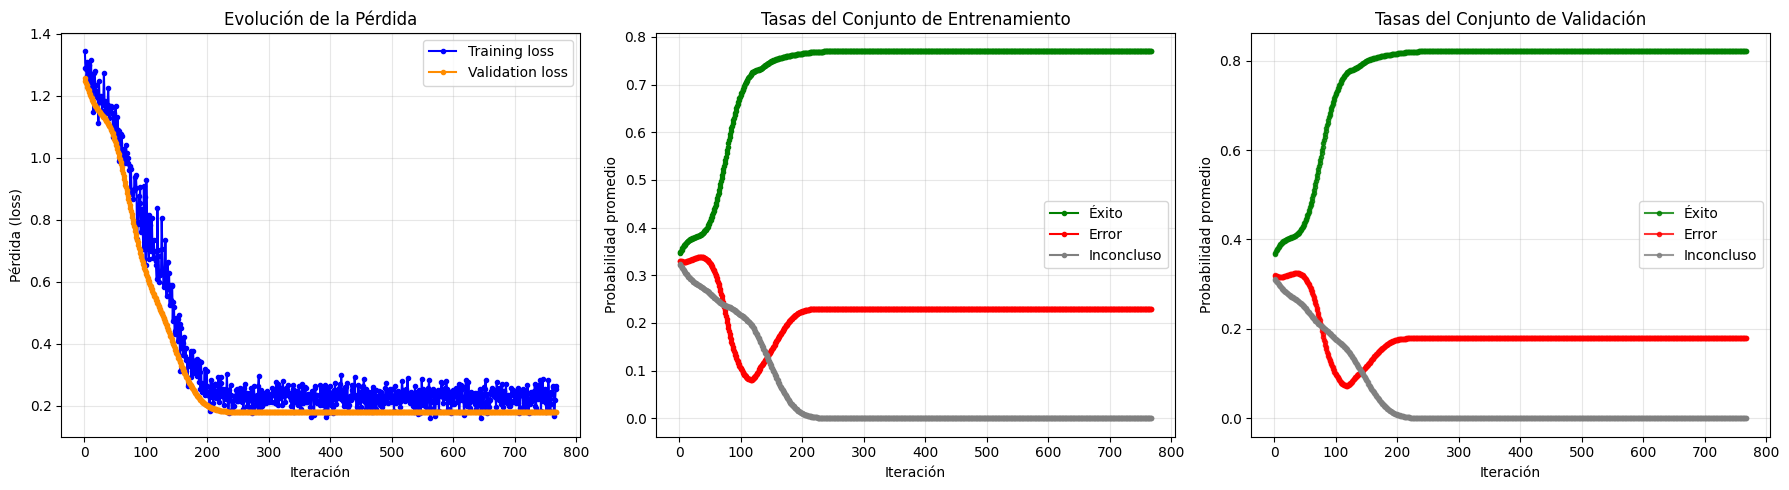

In [13]:
it = len(train_suc_history)

# Visualización de los resultados
plt.figure(figsize=(18, 5))

# 1. Evolución de la pérdida
plt.subplot(1, 3, 1)
plt.plot(range(1, it+1), loss_history, '.-', label="Training loss", color='blue')
plt.plot(range(1, it+1), val_loss_history, '.-', label="Validation loss", color='darkorange')
plt.xlabel("Iteración")
plt.ylabel("Pérdida (loss)")
plt.title("Evolución de la Pérdida")
plt.grid(True, alpha=0.3)
plt.legend()

# 2. Tasas en entrenamiento
plt.subplot(1, 3, 2)
plt.plot(range(1, it+1), train_suc_history, '.-', label="Éxito", color='green')
plt.plot(range(1, it+1), train_err_history, '.-', label="Error", color='red')
plt.plot(range(1, it+1), train_inc_history, '.-', label="Inconcluso", color='gray')
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Entrenamiento")
plt.grid(True, alpha=0.3)
plt.legend()

# 3. Tasas en validación
plt.subplot(1, 3, 3)
plt.plot(range(1, it+1), val_suc_history, '.-', label="Éxito", color='green', alpha=0.8)
plt.plot(range(1, it+1), val_err_history, '.-', label="Error", color='red', alpha=0.8)
plt.plot(range(1, it+1), val_inc_history, '.-', label="Inconcluso", color='gray', alpha=0.8)
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Validación")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

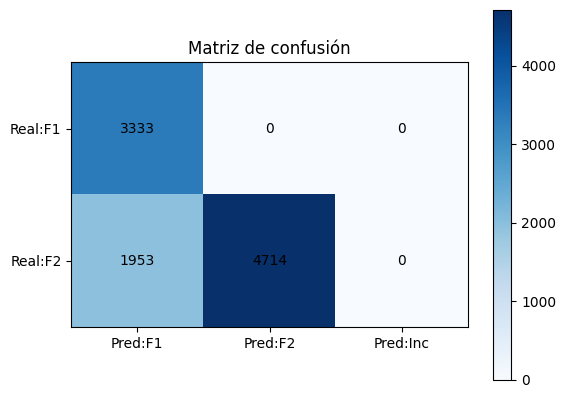

In [14]:
#Matriz de confusión

def predict_label(params, val, actual_label):
    """
    Devuelve la predicción discreta:
      1 => familia 1
      2 => familia 2
      3 => inconcluso


    actual_label se usa para saber qué outcome corresponde a éxito o error.
    """
    probs = get_probabilities(params, val, actual_label)

    p_fam1 = probs[0] + probs[2]
    p_fam2 = probs[1]
    p_inc  = probs[3]

    # Tomamos la mayor de las tres
    idx = np.argmax([p_fam1, p_fam2, p_inc])
    predicted = [1, 2, 3][idx]  # 1=fam1, 2=fam2, 3=inconcluso
    return predicted

def confusion_matrix_inconclusive(params, samples):

    cm = np.zeros((2, 3))
    for (val, actual_label) in samples:
        pred = predict_label(params, val, actual_label)
        row = actual_label - 1  # (1->0, 2->1)
        col = pred - 1          # (1->0, 2->1, 3->2)
        cm[row, col] += 1
    return cm

def plot_confusion_matrix_inconclusive(cm, normalize=False):
    """
    Dibuja la matriz
    """
    cm_display = cm.copy()
    if normalize:
        for i in range(cm_display.shape[0]):
            row_sum = np.sum(cm_display[i, :])
            if row_sum > 0:
                cm_display[i, :] /= row_sum


    fig, ax = plt.subplots()
    im = ax.imshow(cm_display, cmap='Blues', origin='upper')

    # Etiquetas de ejes
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred:F1","Pred:F2","Pred:Inc"])
    ax.set_yticklabels(["Real:F1","Real:F2"])

    # Texto en cada celda
    for i in range(2):
        for j in range(3):
            val = cm_display[i, j]
            if normalize:
                txt = f"{val*100:.1f}%"
            else:
                txt = f"{val:.0f}"
            ax.text(j, i, txt, ha='center', va='center', color='black')

    plt.colorbar(im, ax=ax)
    plt.title("Matriz de confusión")
    plt.show()


cm_test = confusion_matrix_inconclusive(params, data_test)
plot_confusion_matrix_inconclusive(cm_test, normalize=False)
